In [1]:
import os
import torch
import numpy as np

# CODE FILES HERE
from models.tdcvae.tdcvae import Encoder, Decoder, TD_Cvae, MODEL_NAME
from solver import Solver
from dataloader import DataLoader
from directories import Directories
from plots import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space,\
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid,\
plot_prepro_alpha_params_distribution, plot_prepro_radius_params_distribution
from auxiliary import get_latent_spaces, transform_images
from preprocessing import RandomPreprocessing, DeterministicPreprocessing

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutionshttp://localhost:8888/notebooks/3_tdcvae.ipynb#
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda:0

Tesla P4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

optimizer = torch.optim.Adam

if dataset == "MNIST":
    batch_size = 128
    epochs = 5
    hidden_dim = 500
    z_dim = 2
    beta = 1
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 50,
        "gamma" : 0.75 # or 0.1
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [0, 360],
        "theta_2": [0, 60]
    }
    scales = {
        "scale_1": [0.7, 1.3],
        "scale_2": [0.2, 0.5]
    }
if dataset == "LungScans":
    batch_size = 4
    epochs = 1
    hidden_dim = 1000
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    resize = (80, 80)
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [-45, 45],
        "theta_2": [-10, 10]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.5]
    }

In [ ]:
directories = Directories(MODEL_NAME, dataset, z_dim)
data_loader = DataLoader(directories, batch_size, dataset, thetas=thetas)
model = TD_Cvae(data_loader.input_dim, hidden_dim, data_loader.input_dim, z_dim, beta)
solver = Solver(model, data_loader, optimizer, epochs, optim_config, step_config=step_config, lr_scheduler=lr_scheduler, tdcvae_mode=True, save_model_state=True)
solver.main()

In [3]:
#Uncomment to load a model to continue training.
#solver = torch.load("../results/tdcvae/MNIST_z=2_0/model_state.pt")
#solver.main()

In [ ]:
#Uncomment to load a trained model for inference.
#solver = torch.load("../results/saved_models/model_TD_CVAE_SCALES_THETAS_MNIST_train_loss=151.99_z=2.pt", map_location='cpu')
#solver.model.eval()

In [ ]:
# TODO: make something like a dict to insert for plot titles to avoid it has to be taken from solver obj and 
# instead we can los from dumb also.

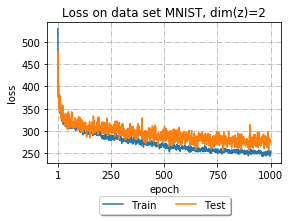

In [4]:
# Plotting train and test losses for all epochs
plot_losses(solver, solver.train_loss_history["train_loss_acc"], solver.test_loss_history)

epoch: 1, mu(z): -0.1060, stddev(z): 1.4061, var(z): 1.9771, var(mu(z)): 0.1787 E[var(q(z|x)]: 1.5072
epoch: 251, mu(z): -0.0520, stddev(z): 1.2793, var(z): 1.6366, var(mu(z)): 0.4845 E[var(q(z|x)]: 0.0164
epoch: 501, mu(z): 0.0293, stddev(z): 1.2761, var(z): 1.6284, var(mu(z)): 0.3670 E[var(q(z|x)]: 0.0088
epoch: 1000, mu(z): 0.0519, stddev(z): 1.1986, var(z): 1.4367, var(mu(z)): 0.3062 E[var(q(z|x)]: 0.0056


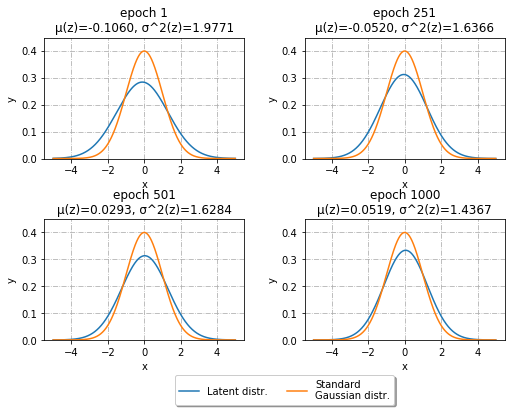

In [5]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver, len(solver.train_loss_history["train_loss_acc"]))

epoch: 1, train_loss: 530.21, test_loss: 444.57, recon. loss: 529.30, KL div.: 0.91
overfitting: 85.64
epoch: 2, train_loss: 429.99, test_loss: 480.16, recon. loss: 427.35, KL div.: 2.64
overfitting: 50.17
epoch: 3, train_loss: 398.39, test_loss: 376.39, recon. loss: 394.86, KL div.: 3.54
overfitting: 22.00
epoch: 4, train_loss: 383.41, test_loss: 406.05, recon. loss: 378.98, KL div.: 4.42
overfitting: 22.65
epoch: 5, train_loss: 372.40, test_loss: 362.24, recon. loss: 367.58, KL div.: 4.82
overfitting: 10.16
epoch: 6, train_loss: 368.69, test_loss: 354.64, recon. loss: 363.80, KL div.: 4.89
overfitting: 14.05
epoch: 7, train_loss: 356.28, test_loss: 356.96, recon. loss: 351.48, KL div.: 4.80
overfitting: 0.67
epoch: 8, train_loss: 357.45, test_loss: 351.46, recon. loss: 352.34, KL div.: 5.12
overfitting: 5.99
epoch: 9, train_loss: 349.03, test_loss: 381.50, recon. loss: 344.10, KL div.: 4.92
overfitting: 32.48
epoch: 10, train_loss: 346.62, test_loss: 343.09, recon. loss: 341.67, KL d

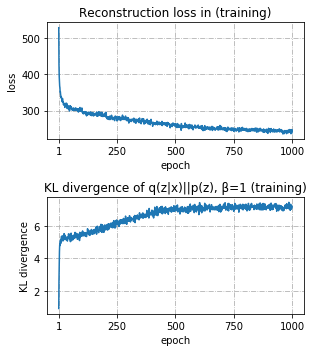

In [6]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 1
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
        solver.train_loss_history["train_loss_acc"], solver.test_loss_history, \
        solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"])

In [19]:
if solver.data_loader.thetas and solver.data_loader.scales:
    transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    solver.data_loader.theta_range_1, solver.data_loader.theta_range_2,\
                                    solver.data_loader.scale_range_1, solver.data_loader.scale_range_2)
elif solver.data_loader.thetas:
    transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    solver.data_loader.theta_range_1, solver.data_loader.theta_range_2)
elif solver.data_loader.scales:
    transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    scale_range_1=solver.data_loader.scale_range_1, scale_range_2=solver.data_loader.scale_range_2)
z_space, y_space, _ = get_latent_spaces(solver, transformation)

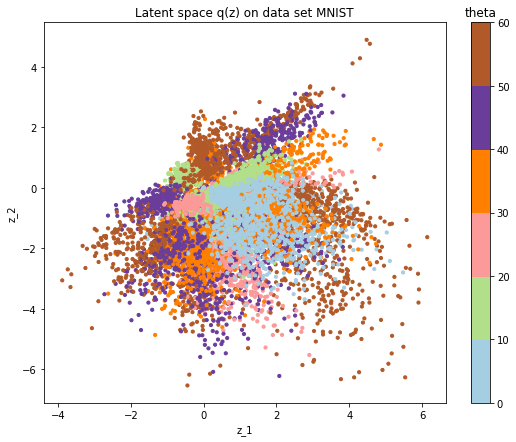

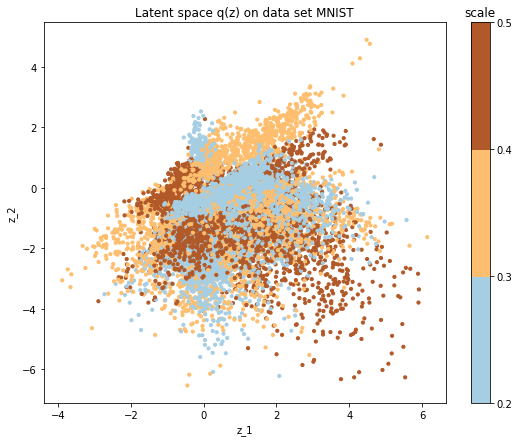

In [20]:
# visualize q(z) (latent space z)
if solver.model.z_dim == 2 and solver.data_loader.thetas or solver.data_loader.scales:
    if solver.data_loader.thetas:
        ticks = np.arange(solver.data_loader.theta_range_2[0], solver.data_loader.theta_range_2[1]+1, 10).tolist()
        labels = transformation.prepro_params["theta_diff"].tolist()
        plot_latent_space(solver, z_space, ticks=ticks, var="z", title="theta", labels=labels, colors=len(ticks)-1)
    if solver.data_loader.scales:
        ticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_2[0]*10),\
                                                       int((solver.data_loader.scale_range_2[1]+0.1)*10))]
        labels = transformation.prepro_params["scale_diff"].tolist()
        plot_latent_space(solver, z_space, ticks=ticks, var="z", title="scale", labels=labels, colors=len(ticks)-1)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

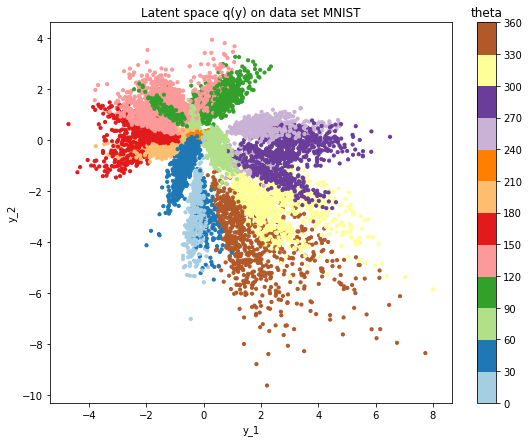

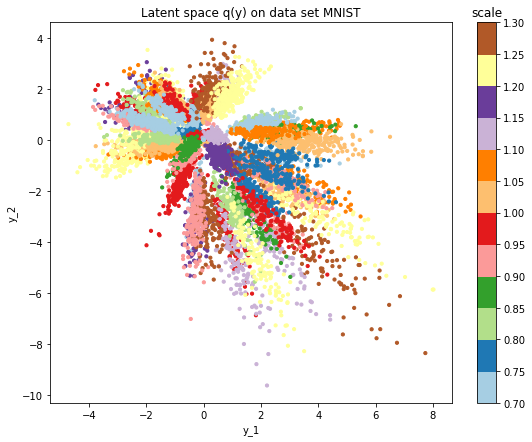

In [21]:
# visualize q(y)
if solver.model.z_dim == 2 and solver.data_loader.thetas or solver.data_loader.scales:
    if solver.data_loader.thetas:
        ticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
        labels = transformation.prepro_params["theta_1"].tolist()
        plot_latent_space(solver, y_space, ticks=ticks, var="y", title="theta", labels=labels)
    if solver.data_loader.scales:
        ticks = np.linspace(solver.data_loader.scale_range_1[0], solver.data_loader.scale_range_1[1], 13).tolist()
        ticks = np.around(ticks, decimals=2)
        labels = transformation.prepro_params["scale_1"].tolist()
        plot_latent_space(solver, y_space, ticks=ticks, var="y", title="scale", labels=labels)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

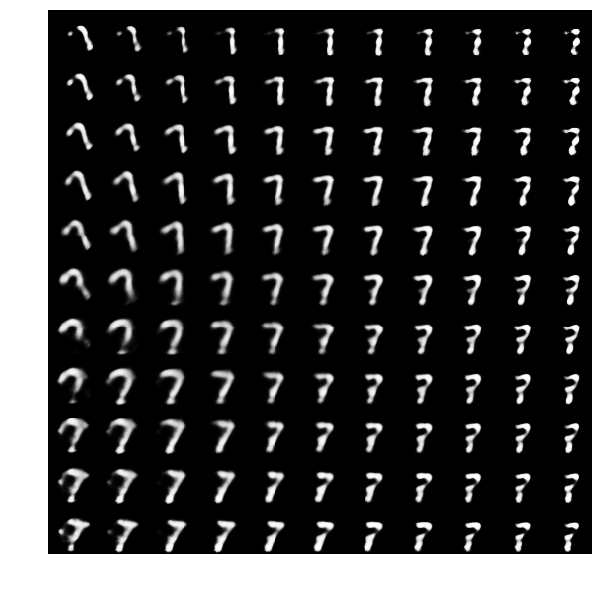

In [28]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.model.z_dim == 2:
    n = 11
    if solver.data_loader.thetas and solver.data_loader.scales:
        grid_x = np.linspace(-2, 4, n)
        grid_y = np.linspace(2, -4, n)
    elif solver.data_loader.thetas:
        grid_x = np.linspace(-4, 4, n)
        grid_y = np.linspace(-4, 4, n)
    elif solver.data_loader.scales:
        grid_x = np.linspace(-3, 3, n)
        grid_y = np.linspace(-3, 3, n)
    test_loader = solver.data_loader.get_new_test_data_loader()
    x_t = iter(test_loader).next()[0]
    x_t, _ = transformation.preprocess_batch(x_t)
    x_t = x_t[0].view(-1, solver.data_loader.input_dim)
    plot_latent_manifold(solver, "bone", grid_x, grid_y, n, x_t=x_t)
else:
    print("Plot is not possible as dimension of z is not 2 or model is loaded")

In [39]:
if solver.data_loader.thetas and solver.data_loader.scales and solver.model.z_dim == 2:
    import time
    test_loader = solver.data_loader.get_new_test_data_loader()
    num_rotations = 30
    num_scales = 5
    num_samples = 20
    det_transformation = DeterministicPreprocessing(num_samples, solver.data_loader.img_dims,\
                                                num_rotations, num_scales, solver.data_loader.theta_range_1,\
                                                solver.data_loader.scale_range_1)
    ys = np.zeros((det_transformation.scales.shape[0], det_transformation.thetas.shape[0], num_samples, 2))
    epoch_watch = time.time()
    transform_images(solver, det_transformation, test_loader, ys)
    torch.save(ys, solver.data_loader.directories.result_dir + "/ys.pt")
    print("{:.2f} min for processing ys".format((time.time() - epoch_watch)/60))

0 0.7 0.0
0 0.7 12.41
0 0.7 24.83
0 0.7 37.24
0 0.7 49.66
0 0.7 62.07
0 0.7 74.48
0 0.7 86.9
0 0.7 99.31
0 0.7 111.72
0 0.7 124.14
0 0.7 136.55
0 0.7 148.97
0 0.7 161.38
0 0.7 173.79
0 0.7 186.21
0 0.7 198.62
0 0.7 211.03
0 0.7 223.45
0 0.7 235.86
0 0.7 248.28
0 0.7 260.69
0 0.7 273.1
0 0.7 285.52
0 0.7 297.93
0 0.7 310.34
0 0.7 322.76
0 0.7 335.17
0 0.7 347.59
0 0.7 360.0
0 0.85 0.0
0 0.85 12.41
0 0.85 24.83
0 0.85 37.24
0 0.85 49.66
0 0.85 62.07
0 0.85 74.48
0 0.85 86.9
0 0.85 99.31
0 0.85 111.72
0 0.85 124.14
0 0.85 136.55
0 0.85 148.97
0 0.85 161.38
0 0.85 173.79
0 0.85 186.21
0 0.85 198.62
0 0.85 211.03
0 0.85 223.45
0 0.85 235.86
0 0.85 248.28
0 0.85 260.69
0 0.85 273.1
0 0.85 285.52
0 0.85 297.93
0 0.85 310.34
0 0.85 322.76
0 0.85 335.17
0 0.85 347.59
0 0.85 360.0
0 1.0 0.0
0 1.0 12.41
0 1.0 24.83
0 1.0 37.24
0 1.0 49.66
0 1.0 62.07
0 1.0 74.48
0 1.0 86.9
0 1.0 99.31
0 1.0 111.72
0 1.0 124.14
0 1.0 136.55
0 1.0 148.97
0 1.0 161.38
0 1.0 173.79
0 1.0 186.21
0 1.0 198.62
0 1.0 211

4 0.85 74.48
4 0.85 86.9
4 0.85 99.31
4 0.85 111.72
4 0.85 124.14
4 0.85 136.55
4 0.85 148.97
4 0.85 161.38
4 0.85 173.79
4 0.85 186.21
4 0.85 198.62
4 0.85 211.03
4 0.85 223.45
4 0.85 235.86
4 0.85 248.28
4 0.85 260.69
4 0.85 273.1
4 0.85 285.52
4 0.85 297.93
4 0.85 310.34
4 0.85 322.76
4 0.85 335.17
4 0.85 347.59
4 0.85 360.0
4 1.0 0.0
4 1.0 12.41
4 1.0 24.83
4 1.0 37.24
4 1.0 49.66
4 1.0 62.07
4 1.0 74.48
4 1.0 86.9
4 1.0 99.31
4 1.0 111.72
4 1.0 124.14
4 1.0 136.55
4 1.0 148.97
4 1.0 161.38
4 1.0 173.79
4 1.0 186.21
4 1.0 198.62
4 1.0 211.03
4 1.0 223.45
4 1.0 235.86
4 1.0 248.28
4 1.0 260.69
4 1.0 273.1
4 1.0 285.52
4 1.0 297.93
4 1.0 310.34
4 1.0 322.76
4 1.0 335.17
4 1.0 347.59
4 1.0 360.0
4 1.15 0.0
4 1.15 12.41
4 1.15 24.83
4 1.15 37.24
4 1.15 49.66
4 1.15 62.07
4 1.15 74.48
4 1.15 86.9
4 1.15 99.31
4 1.15 111.72
4 1.15 124.14
4 1.15 136.55
4 1.15 148.97
4 1.15 161.38
4 1.15 173.79
4 1.15 186.21
4 1.15 198.62
4 1.15 211.03
4 1.15 223.45
4 1.15 235.86
4 1.15 248.28
4 1.15 260.6

8 1.0 111.72
8 1.0 124.14
8 1.0 136.55
8 1.0 148.97
8 1.0 161.38
8 1.0 173.79
8 1.0 186.21
8 1.0 198.62
8 1.0 211.03
8 1.0 223.45
8 1.0 235.86
8 1.0 248.28
8 1.0 260.69
8 1.0 273.1
8 1.0 285.52
8 1.0 297.93
8 1.0 310.34
8 1.0 322.76
8 1.0 335.17
8 1.0 347.59
8 1.0 360.0
8 1.15 0.0
8 1.15 12.41
8 1.15 24.83
8 1.15 37.24
8 1.15 49.66
8 1.15 62.07
8 1.15 74.48
8 1.15 86.9
8 1.15 99.31
8 1.15 111.72
8 1.15 124.14
8 1.15 136.55
8 1.15 148.97
8 1.15 161.38
8 1.15 173.79
8 1.15 186.21
8 1.15 198.62
8 1.15 211.03
8 1.15 223.45
8 1.15 235.86
8 1.15 248.28
8 1.15 260.69
8 1.15 273.1
8 1.15 285.52
8 1.15 297.93
8 1.15 310.34
8 1.15 322.76
8 1.15 335.17
8 1.15 347.59
8 1.15 360.0
8 1.3 0.0
8 1.3 12.41
8 1.3 24.83
8 1.3 37.24
8 1.3 49.66
8 1.3 62.07
8 1.3 74.48
8 1.3 86.9
8 1.3 99.31
8 1.3 111.72
8 1.3 124.14
8 1.3 136.55
8 1.3 148.97
8 1.3 161.38
8 1.3 173.79
8 1.3 186.21
8 1.3 198.62
8 1.3 211.03
8 1.3 223.45
8 1.3 235.86
8 1.3 248.28
8 1.3 260.69
8 1.3 273.1
8 1.3 285.52
8 1.3 297.93
8 1.3 310.3

12 1.0 186.21
12 1.0 198.62
12 1.0 211.03
12 1.0 223.45
12 1.0 235.86
12 1.0 248.28
12 1.0 260.69
12 1.0 273.1
12 1.0 285.52
12 1.0 297.93
12 1.0 310.34
12 1.0 322.76
12 1.0 335.17
12 1.0 347.59
12 1.0 360.0
12 1.15 0.0
12 1.15 12.41
12 1.15 24.83
12 1.15 37.24
12 1.15 49.66
12 1.15 62.07
12 1.15 74.48
12 1.15 86.9
12 1.15 99.31
12 1.15 111.72
12 1.15 124.14
12 1.15 136.55
12 1.15 148.97
12 1.15 161.38
12 1.15 173.79
12 1.15 186.21
12 1.15 198.62
12 1.15 211.03
12 1.15 223.45
12 1.15 235.86
12 1.15 248.28
12 1.15 260.69
12 1.15 273.1
12 1.15 285.52
12 1.15 297.93
12 1.15 310.34
12 1.15 322.76
12 1.15 335.17
12 1.15 347.59
12 1.15 360.0
12 1.3 0.0
12 1.3 12.41
12 1.3 24.83
12 1.3 37.24
12 1.3 49.66
12 1.3 62.07
12 1.3 74.48
12 1.3 86.9
12 1.3 99.31
12 1.3 111.72
12 1.3 124.14
12 1.3 136.55
12 1.3 148.97
12 1.3 161.38
12 1.3 173.79
12 1.3 186.21
12 1.3 198.62
12 1.3 211.03
12 1.3 223.45
12 1.3 235.86
12 1.3 248.28
12 1.3 260.69
12 1.3 273.1
12 1.3 285.52
12 1.3 297.93
12 1.3 310.34
12 1.

16 1.0 37.24
16 1.0 49.66
16 1.0 62.07
16 1.0 74.48
16 1.0 86.9
16 1.0 99.31
16 1.0 111.72
16 1.0 124.14
16 1.0 136.55
16 1.0 148.97
16 1.0 161.38
16 1.0 173.79
16 1.0 186.21
16 1.0 198.62
16 1.0 211.03
16 1.0 223.45
16 1.0 235.86
16 1.0 248.28
16 1.0 260.69
16 1.0 273.1
16 1.0 285.52
16 1.0 297.93
16 1.0 310.34
16 1.0 322.76
16 1.0 335.17
16 1.0 347.59
16 1.0 360.0
16 1.15 0.0
16 1.15 12.41
16 1.15 24.83
16 1.15 37.24
16 1.15 49.66
16 1.15 62.07
16 1.15 74.48
16 1.15 86.9
16 1.15 99.31
16 1.15 111.72
16 1.15 124.14
16 1.15 136.55
16 1.15 148.97
16 1.15 161.38
16 1.15 173.79
16 1.15 186.21
16 1.15 198.62
16 1.15 211.03
16 1.15 223.45
16 1.15 235.86
16 1.15 248.28
16 1.15 260.69
16 1.15 273.1
16 1.15 285.52
16 1.15 297.93
16 1.15 310.34
16 1.15 322.76
16 1.15 335.17
16 1.15 347.59
16 1.15 360.0
16 1.3 0.0
16 1.3 12.41
16 1.3 24.83
16 1.3 37.24
16 1.3 49.66
16 1.3 62.07
16 1.3 74.48
16 1.3 86.9
16 1.3 99.31
16 1.3 111.72
16 1.3 124.14
16 1.3 136.55
16 1.3 148.97
16 1.3 161.38
16 1.3 173.

In [ ]:
# Uncomment to load y spaces for plotting
# ys = torch.load("../results/tdcvae/MNIST_z=2_0/ys.pt")

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
torch.Size([25, 1, 28, 28])


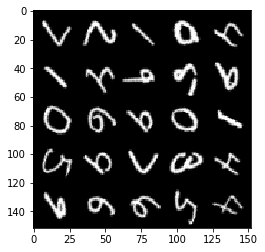

In [151]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import skimage as ski
test_loader = solver.data_loader.get_new_test_data_loader()
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        data, y = data
        data = data[:25].numpy()
        #asd = torch.zeros((25, 1, 36, 36))
        asd = np.zeros((25, 28, 28))
        for i in range(25):
            shift_y, shift_x = np.array(asd.shape[1:3]) / 2.
            center_shift = ski.transform.SimilarityTransform(translation=[-shift_x, -shift_y])
            center_shift_inv = ski.transform.SimilarityTransform(translation=[shift_x, shift_y])
            center_transform = ski.transform.AffineTransform(scale=(1.0, 1.0), rotation=90)
            transformation = center_shift + (center_transform + center_shift_inv)
            print(data[i][0].shape)
            asd[i] = ski.transform.warp(data[i][0], transformation.inverse, output_shape=(asd.shape[1], asd.shape[2]), preserve_range=True)
            #asd[i] = transforms.ToTensor()(TF.resize(transforms.ToPILImage()(data[i]), (35, 35)))
            #asd[i] = transforms.ToTensor()(TF.rotate(transforms.ToPILImage()(asd[i]), 270))
        das = torch.tensor(asd)
        das.unsqueeze_(1)
        print(das.shape)
        grid_img = torchvision.utils.make_grid(das, nrow=5)
        plt.imshow(grid_img.permute(1, 2, 0))
        break

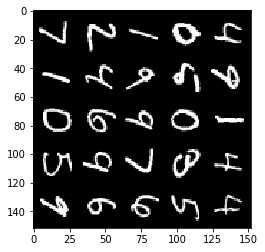

In [150]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import skimage as ski
test_loader = solver.data_loader.get_new_test_data_loader()
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        data, y = data
        asd = torch.zeros((25, 1, 28, 28))
        for i in range(25):
            asd[i] = transforms.ToTensor()(TF.affine(transforms.ToPILImage()(data[i]), 90, [0, 0], 1.0, 0))
            #asd[i] = TF.affine()
        grid_img = torchvision.utils.make_grid(asd, nrow=5)
        plt.imshow(grid_img.permute(1, 2, 0))
        break

In [ ]:
# for rotation
if solver.z_dim == 2 and solver.data_loader.thetas:
    plot_prepro_alpha_params_distribution(solver)
else:
    print("dim(z) is not 2 or rotation mode is not set")

In [ ]:
# for scaling
if solver.z_dim == 2 and solver.data_loader.scales:
    plot_prepro_radius_params_distribution(solver)
else:
    print("dim(z) is not 2 or scaling mode is not set")

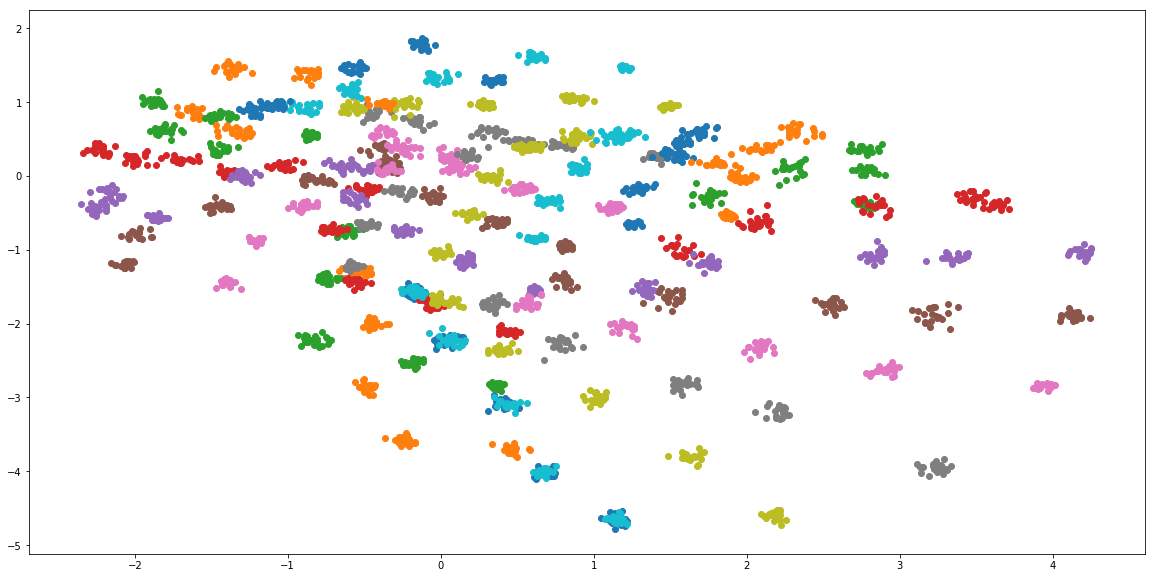

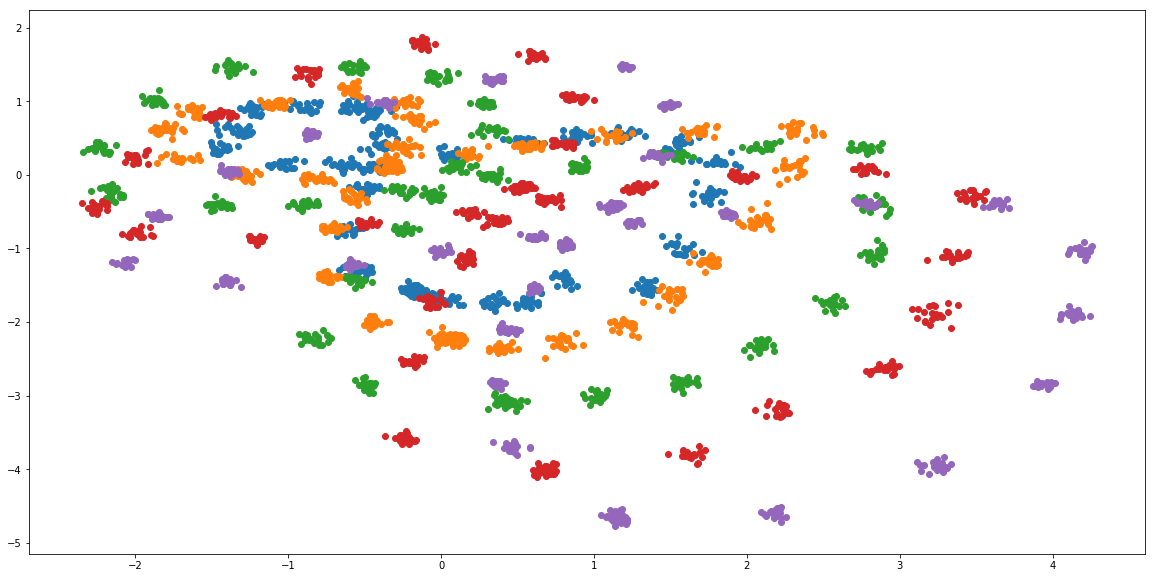

In [66]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
plt.figure(figsize=(20,10))
#print(ys[:,:,0,0].shape)
#print(ys[:,:,0,0].shape)
# ys = np.zeros((transformation.scales.shape[0], transformation.thetas.shape[0], solver.data_loader.num_test_samples, 2))
for t in range(ys.shape[1]):
  plt.scatter(ys[:,t,:,0], ys[:,t,:,1])
plt.show()

plt.figure(figsize=(20,10))
for s in range(ys.shape[0]):
  plt.scatter(ys[s,:,:,0],ys[s,:,:,1])
plt.show()

(30,)
-3.13944543549078 3.139450534678638
(100, 30)
(3000,) (100, 30)


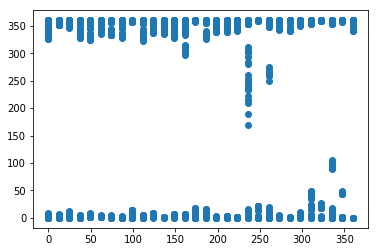

In [69]:
#compute alphas
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1]*ys.shape[2], 2))
meany=np.mean(ysflat, 0, keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
# ys = np.zeros((transformation.scales.shape[0], transformation.thetas.shape[0], solver.data_loader.num_test_samples, 2))
alphas= np.reshape(alphas, (ys.shape[2] * det_transformation.scales.shape[0], det_transformation.thetas.shape[0]))

print(det_transformation.thetas.shape)
print(np.min(alphas), np.max(alphas))
print(alphas.shape)

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas > 0, alphas, alphas+360)


thethos = np.repeat(det_transformation.thetas, alphas.shape[0])
#print(np.min(alphas), np.max(alphas), alphas.shape)
#print(thethos.shape, thethos[19998:20003])
#plt.scatter(thetas[200,:], alphas[200,:])
#plt.scatter(thetas[201,:], alphas[201,:])
#thethos = transformation.thetas # np.tile(np.expand_dims(theta,axis=0),(alphas.shape[0],1))/(2*np.pi)/360
#plt.figure(figsize=(20,10))

print(thethos.shape, alphas.shape)
plt.scatter(thethos.flatten(), alphas.flatten())
plt.show()

#plt.scatter(thethos[200:210], alphas[200:210])
#plt.scatter(thethos[211], alphas[211])

In [ ]:
print(solver.data_loader.prepro_params["theta_1"][1][100:200])
print(solver.y_space.shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
# M, N, 2
ysflat = np.reshape(solver.y_space, (N*M, 2)) # NM, 2
meany = np.mean(ysflat, 0, keepdims=True) # 1, 2
alphas = np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas = np.reshape(alphas, (M, N)).T # 20*5, 30
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)
thetas = solver.data_loader.prepro_params["theta_1"].T # M, N
print(alphas.shape, np.min(alphas), np.max(alphas))
print("thetas", thetas.shape, np.min(ysflat), np.max(ysflat))

#scatter = ax.scatter(thetas.flatten(), alphas.flatten())
print(thetas[200,:], alphas[200,:])
plt.scatter(thetas[200,:], alphas[200,:])
plt.scatter(thetas[201,:], alphas[201,:])

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla


alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))

#paired_cmap = plt.cm.get_cmap("Paired", 12)
#rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
#norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas), len(new_counts), indices, np.min(thetas[indices]), np.max(thetas[indices]))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
solver = torch.load("../results/saved_models/model_TD_CVAE_MNIST_train_loss=88.61_z=2.pt", map_location='cpu')
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()


alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
alphas = np.array([round(x,2) for x in alphas.tolist()])
# TODO: problem: for each batch_size, there are num_generation (thetas, alphas), we have to take that into account!
#thetas = np.repeat(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
classes = np.array(solver.data_labels)
#y_space_labels = np.repeat(solver.data_loader.prepro_params[key], solver.data_loader.batch_size)
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
#print(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
# TODO: make alphas bins and count, but then flatten the counts, and mark by counts values where each new color begins.
#print(np.sum(counts))
#print(alphas.shape, len(thetas), solver.y_space.shape, len(solver.data_loader.prepro_params["theta_1"]), classes)
# move every 10, because every 10th is the angle for index 0.
thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(thetas.shape)

paired_cmap = plt.cm.get_cmap("Paired", 12)
rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
print(alpha_bins)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    #print(counts.sum(), len(alphas_indices))
    #print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        #print(asd, offset, to_fill.shape)
        new_counts[asd:(asd+offset)] = to_fill # 0:len(to_fill), len(to_fill):len(new_to_fill)
        asd += offset
    print(len(new_counts))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
#solver.model.eval()
# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]
alphas = np.around(np.array(alphas), decimals=2)
# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for gen in range(solver.num_generations):
    thetas[:, gen] = np.radians(np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size))
#thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(alphas.shape, thetas.shape)
# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
    
print(alphas.shape, thetas.shape)
    #paired_cmap = plt.cm.get_cmap("Paired", 12)
    #rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
    #norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
#solver.model.eval()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)

# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
# For each batch we go through num_generations iterations/encodings. Thus, 
# if num_generations is 10, for prepro_params, 0-9 is for batch 0, 10-19 for batch 1 and so on. (every time on the same batch)  
idx = 0
for batch_idx in range(solver.data_loader.num_train_batches):
    start = batch_idx*solver.data_loader.batch_size
    end = (batch_idx+1)*solver.data_loader.batch_size
    for gen in range(solver.num_generations):
        thetas[start:end, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][idx], solver.data_loader.batch_size)
        idx += 1
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)

mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
for idx in range(0, alphas.shape[1]):
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    if idx > 0:
        alphas[:, idx] = np.around(alphas[:, idx] - alphas[:, 0] + (np.radians(thetas[:, 0])/(2*np.pi))-0.5, decimals=2)
        #mini = np.min(alphas[:, idx])
        #maxi = np.max(alphas[:, idx])
        #print(mini, maxi)
        #print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))
        neg_indices = np.where(alphas[:, idx] < -0.5)
        pos_indices = np.where(alphas[:, idx] > 0.5)
        alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
        print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))

# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
alphas = np.around(np.array(alphas), decimals=2)

alpha_ranges = alpha_ranges[:-1]
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(np.radians(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

'''
alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))

# compute the alphas
M, N, D = solver.y_space.shape
new_y_space = solver.y_space.reshape((N, M, D))
alphas = torch.zeros((new_y_space.shape[1], new_y_space.shape[2])) # used to be N, D
thetas = np.zeros_like(alphas)
#print(solver.y_space.shape, new_y_space.shape, alphas.shape)
#print(torch.tensor(solver.y_space[: idx, 0]-np.mean(solver.y_space[:, idx, 0])).shape)
for idx in range(solver.y_space.shape[0]):
    print("haha", (torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0]))))
    #alphas[:, idx] = torch.atan2(torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0])),\
    #        torch.tensor(new_y_space[:, idx, 1]-np.mean(new_y_space[:, idx, 1])))/(2*np.pi)
    #thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]

# TODO:oK?
alphas = torch.zeros((solver.y_space.shape[1], solver.y_space.shape[0]))
thetas = np.zeros_like(alphas)
for idx in range(solver.y_space.shape[0]):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] = alphas[:, idx]
'''

# M, N, 2
print(solver.data_loader.prepro_params["theta_1"].shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        
alphas = np.around(np.array(alphas), decimals=2)
mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
print(alphas.shape, thetas.shape)
print(thetas[100:200])

# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, M), decimals=2)
alpha_ranges = alpha_ranges[:-1]
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        print(i, alphas_indices[:, i].shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thetas[indices].flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

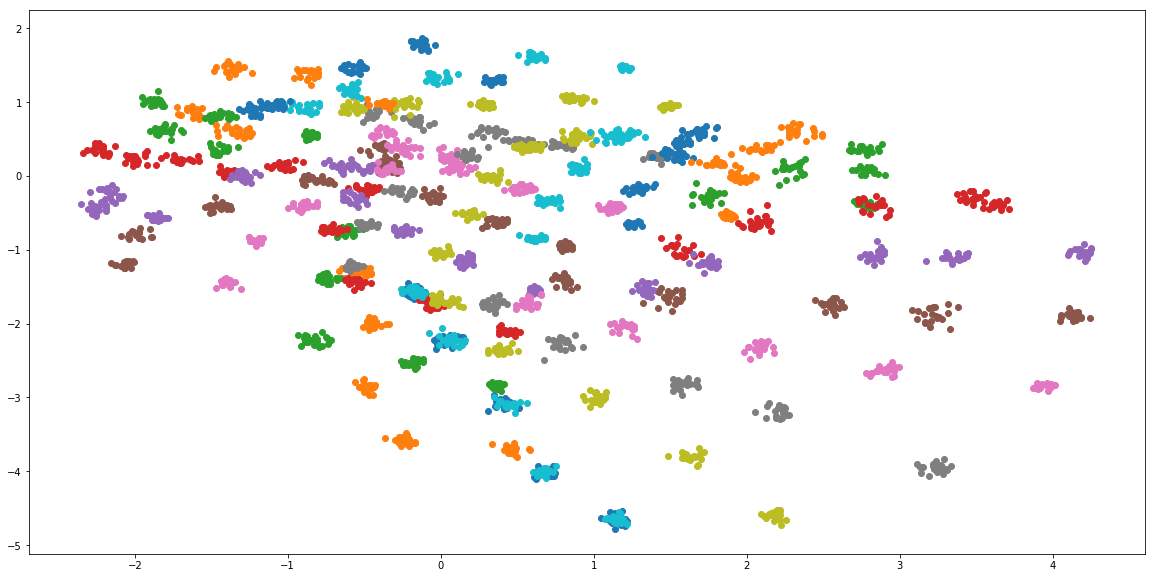

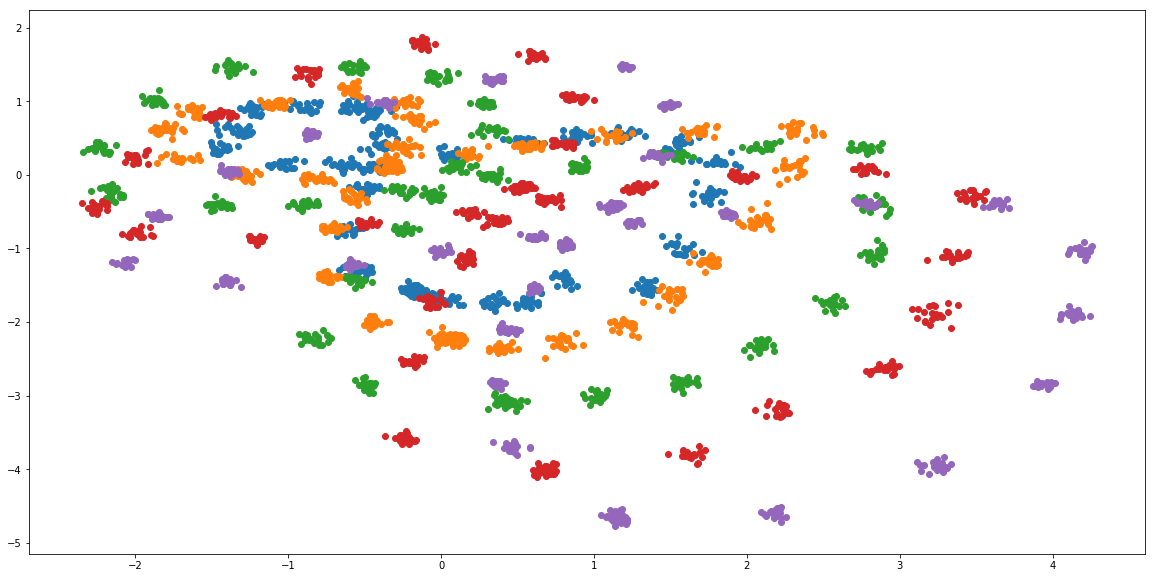

In [57]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
plt.figure(figsize=(20,10))
#print(ys[:,:,0,0].shape)
#print(ys[:,:,0,0].shape)
# ys = np.zeros((transformation.scales.shape[0], transformation.thetas.shape[0], solver.data_loader.num_test_samples, 2))
for t in range(ys.shape[1]):
  plt.scatter(ys[:,t,:,0], ys[:,t,:,1])
plt.show()

plt.figure(figsize=(20,10))
for s in range(ys.shape[0]):
  plt.scatter(ys[s,:,:,0],ys[s,:,:,1])
plt.show()

(30,)
-3.13944543549078 3.139450534678638
(100, 30)


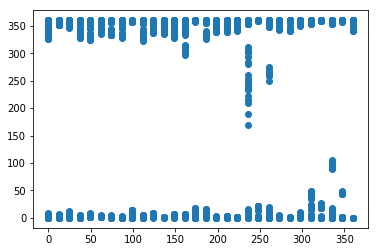

In [54]:
#compute alphas
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1]*ys.shape[2], 2))
meany=np.mean(ysflat, 0, keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
# ys = np.zeros((transformation.scales.shape[0], transformation.thetas.shape[0], solver.data_loader.num_test_samples, 2))
alphas= np.reshape(alphas, (ys.shape[2] * det_transformation.scales.shape[0], det_transformation.thetas.shape[0]))

print(det_transformation.thetas.shape)
print(np.min(alphas), np.max(alphas))
print(alphas.shape)

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas > 0, alphas, alphas+360)


thethos = np.repeat(det_transformation.thetas, alphas.shape[0])
#print(np.min(alphas), np.max(alphas), alphas.shape)
#print(thethos.shape, thethos[19998:20003])
#plt.scatter(thetas[200,:], alphas[200,:])
#plt.scatter(thetas[201,:], alphas[201,:])
#thethos = transformation.thetas # np.tile(np.expand_dims(theta,axis=0),(alphas.shape[0],1))/(2*np.pi)/360
#plt.figure(figsize=(20,10))
plt.scatter(thethos.flatten(), alphas.flatten())
plt.show()

In [ ]:
print(solver.data_loader.prepro_params["theta_1"][1][100:200])
print(solver.y_space.shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
# M, N, 2
ysflat = np.reshape(solver.y_space, (N*M, 2)) # NM, 2
meany = np.mean(ysflat, 0, keepdims=True) # 1, 2
alphas = np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas = np.reshape(alphas, (M, N)).T # 20*5, 30
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)
thetas = solver.data_loader.prepro_params["theta_1"].T # M, N
print(alphas.shape, np.min(alphas), np.max(alphas))
print("thetas", thetas.shape, np.min(ysflat), np.max(ysflat))

#scatter = ax.scatter(thetas.flatten(), alphas.flatten())
print(thetas[200,:], alphas[200,:])
plt.scatter(thetas[200,:], alphas[200,:])
plt.scatter(thetas[201,:], alphas[201,:])

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

######################################################################

#solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
#solver.model.eval()

N, M = ys
M = 2
alphas = np.zeros((N, M))
thetas = np.zeros_like(alphas)
alphas[:, 0] = torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))
alphas[:, 1] = torch.atan2(torch.tensor(solver.y_space[1, :, 0]-np.mean(solver.y_space[1, :, 0])),\
            torch.tensor(solver.y_space[1, :, 1]-np.mean(solver.y_space[1, :, 1])))
alphas = np.array(alphas)
alphas[:, 1] -= alphas[:, 0]
alphas /= (2*np.pi)/360
alphas = np.around(alphas, decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
thetas[:, 1] = solver.data_loader.prepro_params["theta_1"][1]
alphas = np.where(alphas >= 0, alphas, alphas+360)

print(thetas[:, 0])
print(thetas[:, 1])

'''
M=1
alphas = torch.zeros((N, 1))
thetas = np.zeros_like(alphas)
alphas[:, 0] = torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
'''

'''
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    alphas = np.around(np.array(alphas), decimals=2)
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        #neg_indices = np.where(alphas[:, idx] < -0.5)
        #pos_indices = np.where(alphas[:, idx] > 0.5)
        #alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        #alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
alphas = np.around(np.array(alphas), decimals=2)
'''
#solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
#solver.model.eval()

mini = np.min(alphas)
maxi = np.max(alphas)
# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
print(alphas.shape)
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices, 1:] # , 1:
    for i in range(alphas_indices.shape[1]):
        print(i, alphas_indices.shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    thets = thetas[indices, 1:] # , 1:
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thets.flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thets.flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
'''
#compute alphas
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1] * ys.shape[2],2))
meany=np.mean(ysflat,0,keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas= np.reshape(alphas,(ys.shape[0] * s.shape[0], theta.shape[0]))

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas > 0, alphas, alphas+360)
'''
solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
solver.model.eval()

print(solver.data_loader.prepro_params["theta_1"][1][100:200])
print(solver.y_space.shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
# M, N, 2
ysflat = np.reshape(solver.y_space, (N*M, 2)) # NM, 2
meany = np.mean(ysflat, 0, keepdims=True) # 1, 2
alphas = np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas = np.reshape(alphas, (M, N)).T # 20*5, 30
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)
thetas = solver.data_loader.prepro_params["theta_1"].T # M, N
print(alphas.shape, np.min(alphas), np.max(alphas))
print("thetas", thetas.shape, np.min(ysflat), np.max(ysflat))

#scatter = ax.scatter(thetas.flatten(), alphas.flatten())
print(thetas[200,:], alphas[200,:])
plt.scatter(thetas[200,:], alphas[200,:])
plt.scatter(thetas[201,:], alphas[201,:])
'''
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    alphas = np.around(np.array(alphas), decimals=2)
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
alphas = np.around(np.array(alphas), decimals=2)
'''

'''
mini = np.min(alphas)
maxi = np.max(alphas)
# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
print(alphas.shape)
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices] # , 1:
    for i in range(alphas_indices.shape[1]):
        print(i, alphas_indices.shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    thets = thetas[indices] # , 1:
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thets.flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thets.flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
'''

In [ ]:
radiuses = np.zeros((solver.y_space.shape[0], solver.num_generations))
centroid = np.mean(solver.y_space[:, :2], axis=0)
# compute the euclidean distance from each point y_{ij} to the center, so the radiuses
#print(solver.data_loader.train_loader.dataset.transform.transforms.prepro_params)
#print(solver.data_loader.prepro_params["scale_1"])
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)):
    radiuses[:, idx] = bla.cdist(solver.y_space[:, gen_idx:gen_idx+2], np.atleast_2d(centroid)).ravel()
    if idx > 0:
        radiuses[:, idx] -= radiuses[:, 0]
    #radiuses = np.around(np.array(radiuses), decimals=2)
    # prepare the scale from each batch, repeat each set of scales to span over num train samples
#print(solver.data_loader.prepro_params)
scales = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for idx in range(solver.num_generations):
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    scales[:, idx] = np.repeat(solver.data_loader.prepro_params["scale_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    # create the alphas bins, corresponding to the same number as theta bins
mini = np.min(radiuses)
maxi = np.max(radiuses)
radius_ranges = np.around(np.linspace(mini, maxi, 5), decimals=2)
radius_bins = list(zip(radius_ranges[:-1], radius_ranges[1:]))

fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10, 60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(radius_bins))
    radius_indices = radiuses[indices]
    for i in range(radiuses.shape[1]):
        for alpha in radius_indices[:, i]:
            for bin_idx, (x, y) in enumerate(radius_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(radius_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    scatter = ax.scatter(scales[indices, :].flatten(), radius_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [4]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
mode = ""
if solver.data_loader.thetas and solver.data_loader.scales:
    mode = "SCALES_THETAS_"
elif solver.data_loader.thetas:
    mode += "THETAS_"
elif solver.data_loader.scales:
    mode += "SCALES_"
torch.save(solver, solver.data_loader.directories.result_dir + "/model_TD_CVAE_" + mode + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")

AttributeError: 'Solver' object has no attribute 'z_dim'